# The Adam optimizer

The primary usefulness of the adam optimizer is its improved capabilites over other optimizers in almost all cases. To demonstrate this improvement we are going to implement several different optimizers on a basic toy problem.
But first, some set up:

In [143]:
import time
import torch
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torchmetrics.classification import Accuracy
from contextlib import contextmanager
import numpy as np
import torch
import matplotlib.pyplot as plt

In [144]:
# function for measuring time taken curtises of ChatGPT 
@contextmanager
def time_block(label="Elapsed time"):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print(f"{label} elapsed time: {end - start:.6f} seconds")

# function for measuring accuracy
def get_acc(X_test, y_test,classifier):
    num_classes = 10
    acc = Accuracy(task="multiclass", num_classes=num_classes)
    classifier.eval()
    with torch.no_grad():
        y_pred = classifier(torch.from_numpy(X_test).float())  # [899, 10] 
        y_true = torch.tensor(y_test)                           # [899]
        # Convert logits → predicted class indices
        y_pred_labels = torch.argmax(y_pred, dim=1)             # [899]
    accuracy = acc(y_pred_labels, y_true).item()
    print(
        f"Final accuracy: {accuracy:.4f}"
    )

def test_function(x,y):
    return 2*x**2 + 8*y**2


### Toy digits dataset

In [145]:
digits = load_digits()
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1)) #flattens the data
X_train, X_test, y_train, y_test = train_test_split( #splits into training and testing sets
    data, digits.target, test_size=0.5, shuffle=False
)

### Basic Classification Model

Now we are going to define a classification model class, a pretty basic one, but we will be changing up the optimizer on this model to compare perforamces.

In [4]:
class classifier_model(torch.nn.Module):
    
    def __init__(self,input_size,output_size):
        super().__init__()
        self.layer1 = torch.nn.Sequential(torch.nn.Linear(input_size,output_size)) # single layer model
        
    def forward(self,X):
        z = self.layer1(X)         # Apply the first layer (and only)
        return(z)            # Return the result (and the latent space variable

#training a model automatically
def train_model(L,optimizer,classifier, X_train, y_train, display=False):
    n_epochs = 15
    for epoch in range(n_epochs):
        loss = 0
        for X,y in zip(X_train,y_train): #y are labels
            labels = torch.tensor(y)
            inputs = torch.from_numpy(X).to(torch.float32)
        
            optimizer.zero_grad()  # Clear gradients
            outputs = classifier(inputs) #gets the outputs of the model
            train_loss = L(outputs,labels) #gets loss
            train_loss.backward() # compute accumulated gradients
            optimizer.step()# perform parameter update based on current gradients
            loss += train_loss.item() # add the mini-batch training loss to epoch loss
        loss = loss / len(X_train) # compute the epoch training loss
        if display:
            print(f"epoch : {epoch + 1}/{n_epochs}, loss = {loss}")
    return loss #this is the final loss at the end of all the training process
            

## Adam. 

The first optimizer we are going to mess around with is the Adam optimizer 

### Gradient Scaling
Unlike some basic optimizers, the Adam Optimizer is invariant to gradient scaling, so the default learning rate works well for most datasets. Run the optimizer on scaled parameters (scaling parameters scales the gradient) and compare the final accuracy. Is there any scalar that causes a noticable decrease in performance? Then, try the same (or different) scalars on Stochastic Gradient Descent. When does accuracy start to drop?

In [146]:
# test_f: is a two input, one output function
# returns two lists, a list of all weights as they were updated,
# and the z_values, of the value of the function when evaluated at that weight combo
# and the grad_list, or the list of gradients at each time step
# x is the inputs that need to be tensors with requires grad true, and be 2 input
def get_gradient_info(test_f,optimizer,x):
    
    final_list = []
    grad_list = []
    for step in range(100):
        optimizer.zero_grad()
        z = test_f(x[0],x[1])
        z.backward()
        optimizer.step()
        grad_list.append(x.grad)
        final_list.append([x.detach().numpy()[0],x.detach().numpy()[1]])

    weights = np.array(final_list)
    weights = weights.squeeze()

    z_values = []
    for dot in weights:
        z_values.append(test_f(dot[0],dot[1]))

    return weights, z_values, grad_list

In [147]:
# test_f is the function we are trying to minimize
# weights are the value of the inputs we record as the gradient moves along
# z_values is the value of the function at those various weights
# grad_list is the value of the gradient at those various points
def make_graphic(test_f,weights,z_values,grad_list,elev=30,azim=70):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(weights[:,0],weights[:,1],z_values,s=5)

    m_plot = 500
    x1_plot = np.linspace(weights[:,0].min()-.1,weights[:,0].max()+.1,m_plot)
    x2_plot = np.linspace(weights[:,1].min()-.1,weights[:,1].max()+.1,m_plot)
    x1_plot, x2_plot = np.meshgrid(x1_plot,x2_plot)
    #y_plot = 2*x1_plot**2 + 8*x2_plot**2
    y_plot = test_f(x1_plot,x2_plot)
    #y_plot = (3-x1_plot)**2 + 7*(x2_plot-x1_plot**2)**2

    ax.plot_surface(x1_plot,x2_plot,y_plot,color='red',alpha=.3)
    iter = 0
    for x,y,z in zip(weights[:,0],weights[:,1],z_values):
        ax.quiver(
            x, y, z,  # Start coordinates (X, Y, Z)
            -x+grad_list[iter][0]*.001,-y+grad_list[iter][1]*.001,0,    # Direction components (U, V, W)
            length=.05,
            color='g',              # Arrow color
            arrow_length_ratio=0.8  # Adjust head size relative to the arrow length
        )
    ax.view_init(elev=30,azim=70)

Adam optimizer elapsed time: 0.023419 seconds


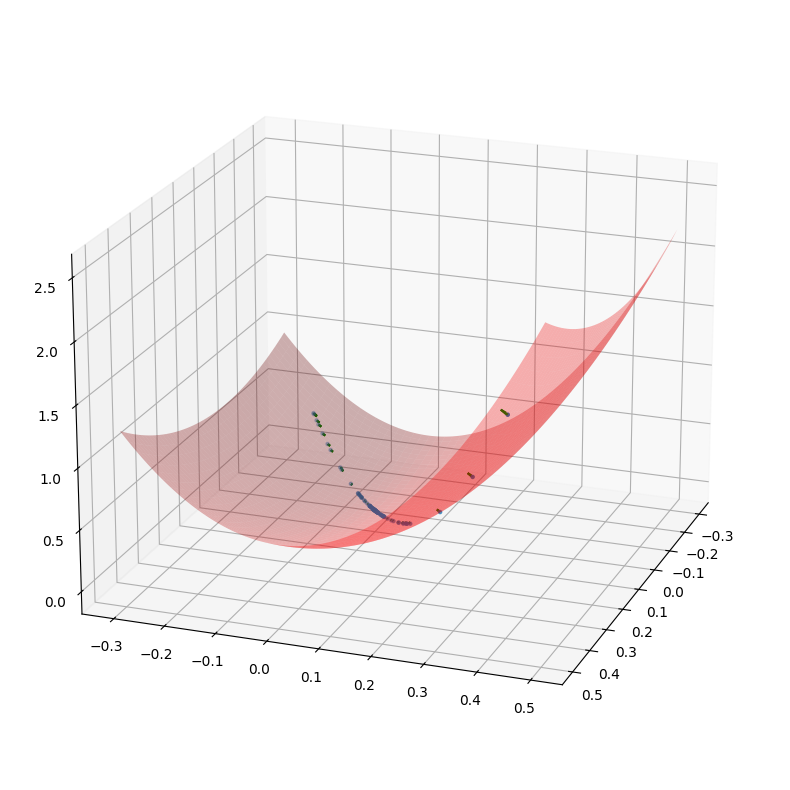

In [ ]:
'''
Here is our function that we want to minimize:
'''
def test_f_2(x,y):
    return 2*x**2 + 8*y**2

'''
We know need to implmenet the optimizer for this function, which is what youll do!
Remember, the parameters for this function need to be inputed into the optimizer as: 
[x]
Remember that!

After you do that, play around with the learning rate you settle on, see if you can get it to optimize as fast as possible!
See what happens to the graph and the time elapsed when the learning rate is big vs small.
Try changing the inital values of the inputs (the x values) and see what happens.
'''

x = torch.tensor([.5,.5], requires_grad=True)
### Make an optimizer:
optimizer = torch.optim.Adam([x], lr=0.1)  #!REMOVE
###
with time_block("Adam optimizer"):   
    weights, z_values, grad_list = get_gradient_info(test_f_2,optimizer,x)
make_graphic(test_f_2,weights, z_values, grad_list)

Adam optimizer elapsed time: 0.022740 seconds


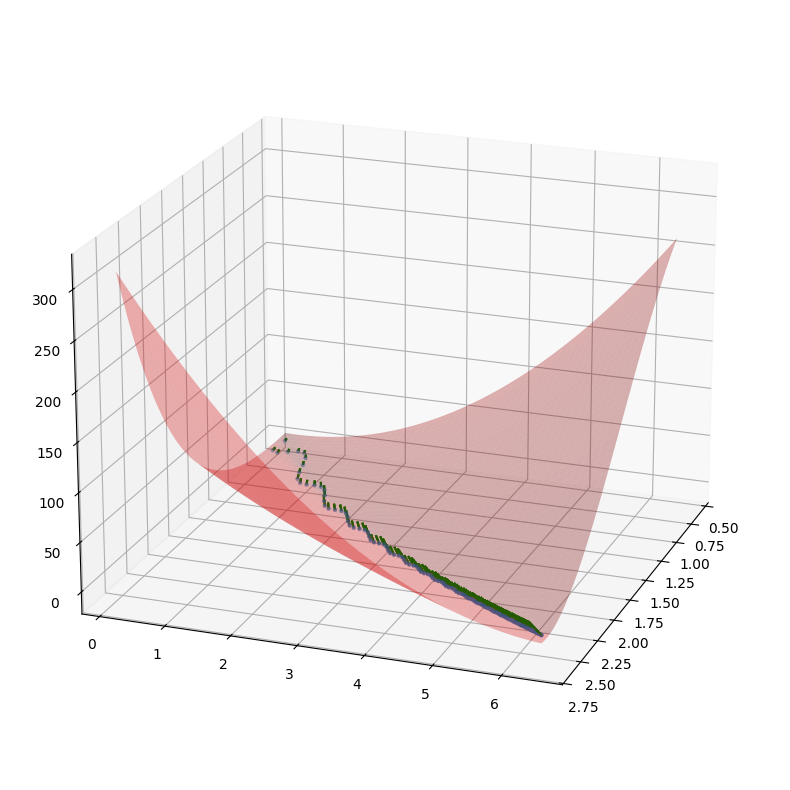

In [134]:
def banana_function(x,y):
    return (3-x)**2 + 7*(y-x**2)**2
'''
Time for round two, this time we have a more interesting function
Remember, the parameters for this function need to be inputed into the optimizer as: 
[x]
Remember that!

After you do that, play around with the learning rate you settle on, see if you can get it to optimize as fast as possible!
See what happens to the graph and the time elapsed when the learning rate is big vs small.
Try changing the inital values of the inputs (the x values) and see what happens.
'''
x = torch.tensor([.5,.5], requires_grad=True)
### Make an optimizer:
optimizer = torch.optim.Adam([x], lr=0.2)  #!REMOVE
###
with time_block("Adam optimizer"):   
    weights, z_values, grad_list = get_gradient_info(banana_function,optimizer,x)
make_graphic(banana_function,weights, z_values, grad_list)

### More optimizers

Now that we have gone over Adam, lets see what it was improving on. Things like Adagrad, RMSprop, and SGD, now you will get to see how they compare to the Adam optimizer.

Be sure to explore and try things out! Different learning rates will often lead to different and interesting behiavor so try and see what you can make happen.

### SGD

Adam optimizer elapsed time: 0.023381 seconds


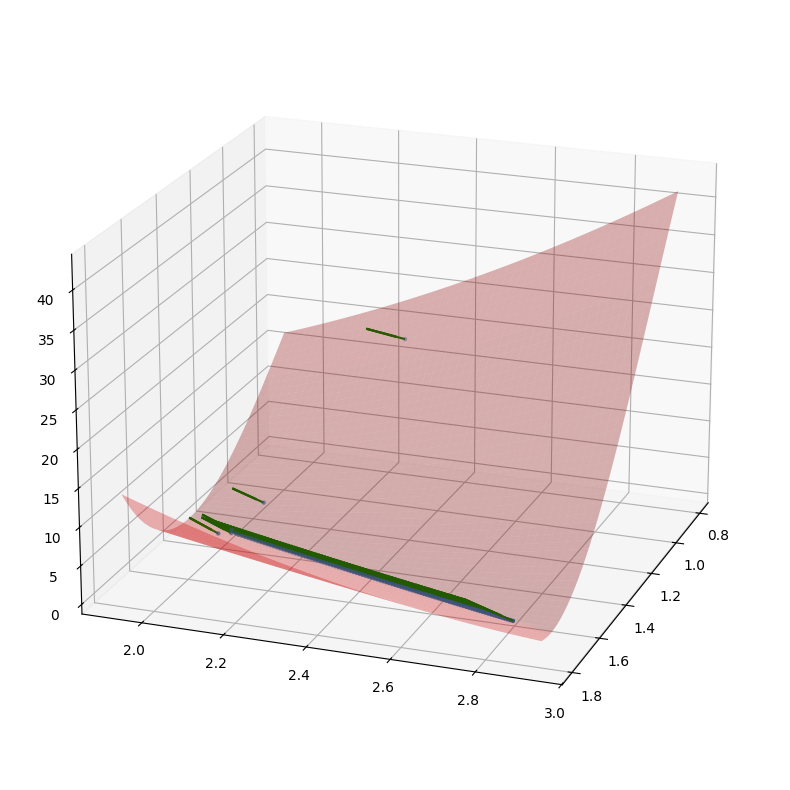

In [139]:
'''
Time for round two, this time we have a more interesting function
Remember, the parameters for this function need to be inputed into the optimizer as: 
[x]
Remember that!

After you do that, play around with the learning rate you settle on, see if you can get it to optimize as fast as possible!
See what happens to the graph and the time elapsed when the learning rate is big vs small.
Try changing the inital values of the inputs (the x values) and see what happens.

'''
x = torch.tensor([2.0,2.0], requires_grad=True)
### Make an optimizer:
optimizer = torch.optim.SGD([x], lr=0.01)  #!REMOVE
###
with time_block("Adam optimizer"):   
    weights, z_values, grad_list = get_gradient_info(banana_function,optimizer,x)
make_graphic(banana_function,weights, z_values, grad_list)

Adam optimizer elapsed time: 0.096790 seconds


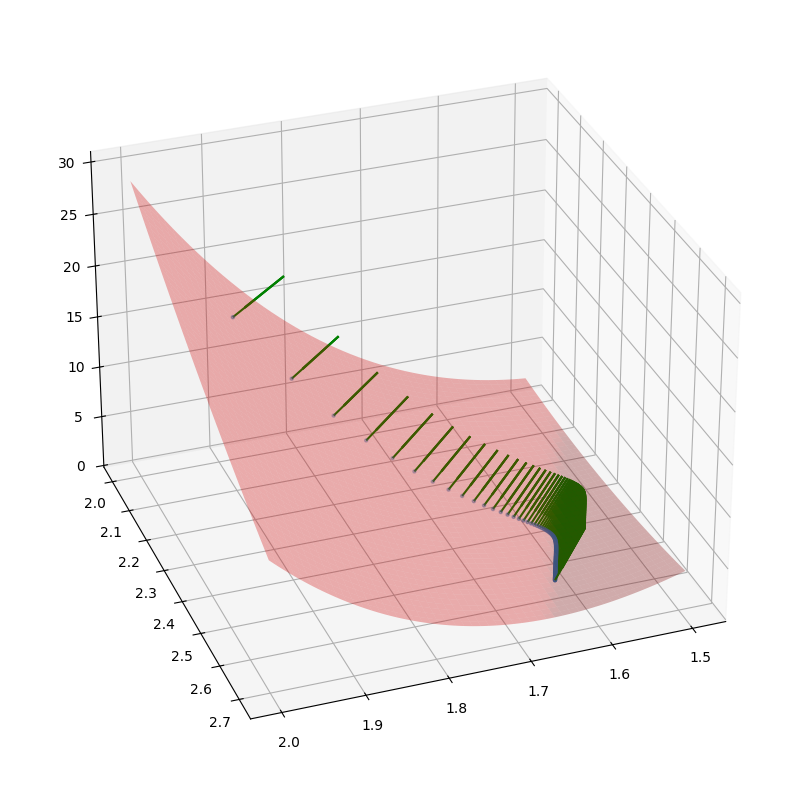

In [143]:
'''
Time for round two, this time we have a more interesting function
Remember, the parameters for this function need to be inputed into the optimizer as: 
[x]
Remember that!

After you do that, play around with the learning rate you settle on, see if you can get it to optimize as fast as possible!
See what happens to the graph and the time elapsed when the learning rate is big vs small.
Try changing the inital values of the inputs (the x values) and see what happens.

'''
x = torch.tensor([2.0,2.0], requires_grad=True)
### Make an optimizer:
optimizer = torch.optim.RMSprop([x], lr=0.01)  #!REMOVE
###
with time_block("Adam optimizer"):   
    weights, z_values, grad_list = get_gradient_info(banana_function,optimizer,x)
make_graphic(banana_function,weights, z_values, grad_list)

Adam optimizer elapsed time: 0.052234 seconds


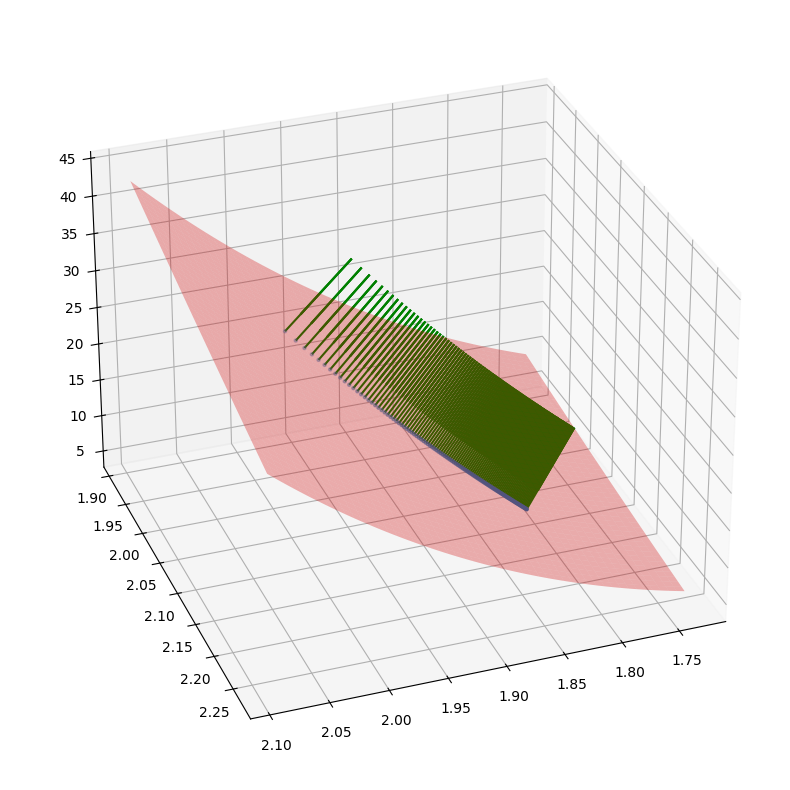

In [146]:
'''
Time for round two, this time we have a more interesting function
Remember, the parameters for this function need to be inputed into the optimizer as: 
[x]
Remember that!

After you do that, play around with the learning rate you settle on, see if you can get it to optimize as fast as possible!
See what happens to the graph and the time elapsed when the learning rate is big vs small.
Try changing the inital values of the inputs (the x values) and see what happens.

'''
x = torch.tensor([2.0,2.0], requires_grad=True)
### Make an optimizer:
optimizer = torch.optim.Adagrad([x], lr=0.01)  #!REMOVE
###
with time_block("Adam optimizer"):   
    weights, z_values, grad_list = get_gradient_info(banana_function,optimizer,x)
make_graphic(banana_function,weights, z_values, grad_list,elev=30,azim=70)


Adam optimizer elapsed time: 0.026163 seconds


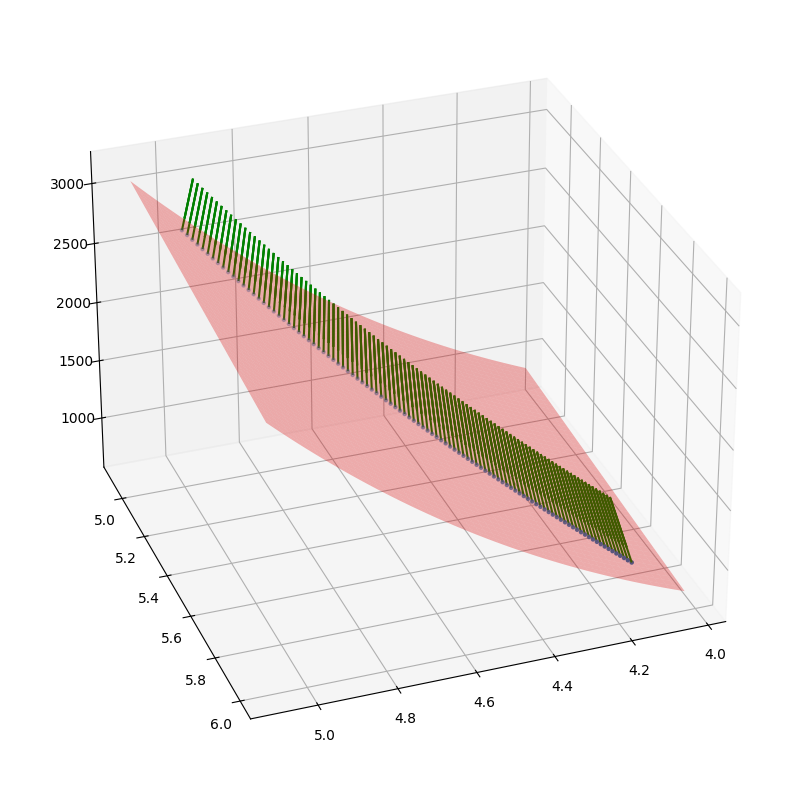

In [ ]:
'''

Once again, implament adam, but this time notice how we have scaled out function 

Remember, the parameters for this function need to be inputed into the optimizer as: 
[x]
Remember that!

After you do that, play around with the learning rate you settle on, see if you can get it to optimize as fast as possible!
See what happens to the graph and the time elapsed when the learning rate is big vs small.
Try changing the inital values of the inputs (the x values) and see what happens.

'''
def banana_function_big(x,y):
    return (30000-x)**2 + 70000*(y-x**2)**2
x = torch.tensor([5.0,5.0], requires_grad=True)
### Make an optimizer:
optimizer = torch.optim.Adam([x], lr=0.01)  #!REMOVE
###
with time_block("Adam optimizer"):   
    weights, z_values, grad_list = get_gradient_info(banana_function,optimizer,x)
make_graphic(banana_function,weights, z_values, grad_list,elev=30,azim=70)

In [ ]:
"""
Scale the training/testing data. Compare the accuracies.
"""
classifier = classifier_model(64,10) #defines the model
##################### Have people do?
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3) #adam optimizer for the gradient decent
L = torch.nn.CrossEntropyLoss()
#####################
X_train_scaled = X_train/50
with time_block("Adam optimizer"):
    final_loss = train_model(L,optimizer,classifier, X_train_scaled, y_train)
    get_acc(X_test/50, y_test,classifier)


classifier = classifier_model(64,10) #defines the model
##################### Have people do?
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3) #adam optimizer for the gradient decent
L = torch.nn.CrossEntropyLoss()
#####################
X_train_scaled = X_train*50
with time_block("Adam optimizer"):
    final_loss = train_model(L,optimizer,classifier, X_train_scaled, y_train)
    get_acc(X_test*50, y_test,classifier)

Final accuracy: 0.9032
Adam optimizer elapsed time: 1.250283 seconds
Final accuracy: 0.8854
Adam optimizer elapsed time: 1.240831 seconds


### Compare this with regular Stochastic Gradient Descent

In [ ]:
classifier = classifier_model(64,10) #defines the model
"""
Now, run Stochastic Gradient Descent with at least twice with different scalars. Compare the change in accuracy to the Adam Optimizer.
"""
##################### Have people do?
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-3) 
L = torch.nn.CrossEntropyLoss()
#####################
with time_block("SGD optimizer"):
    final_loss = train_model(L,optimizer,classifier, X_train*(1/5), y_train)
    get_acc(X_test*(1/5), y_test,classifier)

classifier = classifier_model(64,10) #defines the model
with time_block("SGD optimizer"):
    final_loss = train_model(L,optimizer,classifier, X_train*(5), y_train)
    get_acc(X_test*(5), y_test,classifier)

classifier = classifier_model(64,10) #defines the model (!WITHOUT SCALING)
with time_block("SGD optimizer"):
    final_loss = train_model(L,optimizer,classifier, X_train, y_train)
    get_acc(X_test, y_test,classifier)

Final accuracy: 0.9166
SGD optimizer elapsed time: 0.850014 seconds
Final accuracy: 0.0601
SGD optimizer elapsed time: 0.827783 seconds
Final accuracy: 0.0779
SGD optimizer elapsed time: 0.832517 seconds


If scaling does not affect the data, what about normalization? Compare the accuracy of the model before and after normalization. As a bonus, implement both with cross validation for more stable results!

In [ ]:
"""
Normalize the training/testing data and run the classifier using the Adam optimizer
"""
classifier = classifier_model(64,10) #defines the model
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3) #adam optimizer for the gradient decent
L = torch.nn.CrossEntropyLoss()

mean = np.mean(X_train, axis=0, keepdims=True) 
std  = np.std(X_train, axis=0, keepdims=True)   

eps = 1e-8
X_train_scaled = (X_train - mean) / (std + eps)
X_test_scaled  = (X_test  - mean) / (std + eps)


with time_block("Adam optimizer"):
    final_loss = train_model(L,optimizer,classifier, X_train_scaled, y_train)
    get_acc(X_test_scaled, y_test,classifier)

Final accuracy: 0.9232
Adam optimizer elapsed time: 1.285929 seconds


### The Adam Optimizer is based off of both RMSProp and AdaGrad.
Empirically, is there any difference in accuracy for this basic dataset?

In [ ]:
"""
Run the classifier with RMSprop using the built-in torch function
"""
classifier = classifier_model(64,10) #defines the model
##################### Have people do?
optimizer = torch.optim.RMSprop(classifier.parameters(), lr=1e-3)
L = torch.nn.CrossEntropyLoss()
#####################
with time_block("RMSprop optimizer"):
    final_loss = train_model(L,optimizer,classifier, X_train, y_train)
    get_acc(X_test, y_test,classifier)

Final accuracy: 0.9121
RMSprop optimizer elapsed time: 1.134582 seconds


In [ ]:
"""
Run the classifier with Adagrad using the built-in torch function. Adaprop specifically is known to have issues with step size decreasing too drastically. 
Does accuracy improve with a different learning rate?
"""
classifier = classifier_model(64,10) #defines the model
##################### Have people do?
optimizer = torch.optim.Adagrad(classifier.parameters(), lr=1e-2)
L = torch.nn.CrossEntropyLoss()
#####################
#train_model(L,optimizer,classifier)
with time_block("Adagrad optimizer"):
    final_loss = train_model(L,optimizer,classifier, X_train, y_train)
    get_acc(X_test, y_test,classifier)
    print(f"This is the final loss of the model: {final_loss}")

Final accuracy: 0.8988
This is the final loss of the model: 0.10391850931691522
Adagrad optimizer elapsed time: 1.153268 seconds


# Newtons method

What Adam does is related to a method called Newtons method.

Newtons method works by calcuating local curvuture information using second partial derivatives of your objective function to get a sense of what directions you can speed along, and what ones you want to move more carefully

One would think that if newtons method is so exact that we would want to use it more often. Unfortunualy the hessian is a slow matrix to calculate. As you more then likely noticed, using the full hessian is time consuming so we dont want to do that, additionally we have a dimensionality problem as you will see here:

# The Speed of the hessian matrix



In [ ]:
import torch
from torch.func import hessian, jacfwd, jacrev
'''
# 1. Define a function that returns a single scalar loss
def compute_loss(model_params, input_data, targets, model, loss_fn):
    # Use functional_call to call the model with specific parameters
    outputs = torch.func.functional_call(model, model_params, input_data)
    loss = loss_fn(outputs, targets)
    return loss

# 2. Instantiate your model and loss function
model = torch.nn.Linear(10, 1) # Example model
loss_fn = torch.nn.MSELoss()    # Example loss function
input_data = torch.randn(1, 10)
targets = torch.randn(1, 1)

# 3. Extract parameters as a flat dictionary or tuple (functorch format)
# Note: make_functional is a utility to easily get functional model and params
from torch.func import make_functional
fnet, params = make_functional(model)

# 4. Compute the Hessian
# We need to wrap the loss computation in a function that takes params as input
def get_hessian_func(params):
    return compute_loss(params, input_data, targets, model, loss_fn)

# Calculate the full Hessian matrix
# argnums=0 specifies we want the Hessian with respect to the first argument (params)
full_hessian = hessian(get_hessian_func, argnums=0)(params)
'''

'\n# 1. Define a function that returns a single scalar loss\ndef compute_loss(model_params, input_data, targets, model, loss_fn):\n    # Use functional_call to call the model with specific parameters\n    outputs = torch.func.functional_call(model, model_params, input_data)\n    loss = loss_fn(outputs, targets)\n    return loss\n\n# 2. Instantiate your model and loss function\nmodel = torch.nn.Linear(10, 1) # Example model\nloss_fn = torch.nn.MSELoss()    # Example loss function\ninput_data = torch.randn(1, 10)\ntargets = torch.randn(1, 1)\n\n# 3. Extract parameters as a flat dictionary or tuple (functorch format)\n# Note: make_functional is a utility to easily get functional model and params\nfrom torch.func import make_functional\nfnet, params = make_functional(model)\n\n# 4. Compute the Hessian\n# We need to wrap the loss computation in a function that takes params as input\ndef get_hessian_func(params):\n    return compute_loss(params, input_data, targets, model, loss_fn)\n\n# Calc

In [ ]:
def test_func(x):
    return (x.sin()).sum()
x = torch.randn(100) #takes in 5 inputs, so 5x5 hessian
y = torch.randn(5)

full_hessian = hessian(test_func, argnums=0)(x)
print(full_hessian)

tensor([[-0.3665, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.3835,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.6217,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5572,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.3690, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.9950]])


The Hessian encodes local curvature of the objective function, it allows the gradient to be scaled so that 'dierctions' that have little movement are downscaled, while directions with more curvuture are scaled up so more progress is made.

However this means in high dimensions we are calcuating THOUSANDS of values to figure out this curvture, and for full felgded models, this is simply not computationally doable

In [ ]:
torchmin.newton._minimize_newton_exact(test_func,torch.randn(5))

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: tensor(-5.)
       x: tensor([-1.5708, -1.5708, -1.5708, -1.5708, -1.5708])
     nit: 9
    grad: tensor([-4.3711e-08, -4.3711e-08, -4.3711e-08, -4.3711e-08, -4.3711e-08])
    hess: tensor([[1., 0., 0., 0., 0.],
                  [0., 1., 0., 0., 0.],
                  [0., 0., 1., 0., 0.],
                  [0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 1.]])
    nfev: 23
   nfail: 3